In [ ]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import path, getcwd, chdir
from IPython.display import clear_output
import sys
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import shutil
from shutil import copyfile
import os
import copy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import path, getcwd, chdir
from IPython.display import clear_output
import sys
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import shutil
from shutil import copyfile
import os
import copy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Cropping2D, Conv2D, Conv2DTranspose, MaxPooling2D, Softmax
from tensorflow.keras.layers import Input, Add, Multiply, Lambda, Concatenate, Dropout
import tensorflow.keras.backend as K


2.11.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rm -r Sample_E2E1

In [ ]:
!unzip /content/drive/MyDrive/Sample_E2E_ManualThousand.zip -d Sample_E2E1

clear_output()

##### Preparing Data
Split Data manually into training, validation and test set with corresponding Masks

In [ ]:
TestIrisDir= '/content/Sample_E2E1/Sample_E2E_Manual10/TestN/RawIris'
TrainIrisDir='/content/Sample_E2E1/Sample_E2E_Manual10/Train/RawIris'
ValidIrisDir='/content/Sample_E2E1/Sample_E2E_Manual10/Validation/RawIris'

TestMasksDir='/content/Sample_E2E1/Sample_E2E_Manual10/TestN/Masks'
TrainMasksDir='/content/Sample_E2E1/Sample_E2E_Manual10/Train/Mask'
ValidMasksDir='/content/Sample_E2E1/Sample_E2E_Manual10/Validation/Masks'

AugmnetationIrisDir='/content/Sample_E2E1/Sample_E2E_Manual10/Augmentation/RawIris'
AugmentationMaskDir='/content/Sample_E2E1/Sample_E2E_Manual10/Augmentation/Masks'

In [ ]:
#Setup for the Augmentation

seed = 42

Input_size=(256,256)
data_gen_args = dict(#featurewise_center=True,
                     #featurewise_std_normalization=True,
                     rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.1,
                     rescale=1./255)
Train_Image_datagen = ImageDataGenerator(**data_gen_args)
Train_Mask_datagen = ImageDataGenerator(**data_gen_args)


Train_Image_generator = Train_Image_datagen.flow_from_directory(TrainIrisDir,target_size=Input_size, color_mode='grayscale', batch_size=8, class_mode=None, seed=seed,save_to_dir=AugmnetationIrisDir, save_prefix='AG', save_format='png',)
Train_Mask_generator = Train_Mask_datagen.flow_from_directory(TrainMasksDir,target_size=Input_size, color_mode='grayscale', batch_size=8, class_mode=None, seed=seed,save_to_dir=AugmentationMaskDir, save_prefix='AG', save_format='png',)


In [ ]:
Test_Seed = 42
Test_Image_Datagen=ImageDataGenerator(rescale=1./255)
Test_Mask_Datagen=ImageDataGenerator(rescale=1./255)

Test_Image_generator = Test_Image_Datagen.flow_from_directory(TestIrisDir,target_size=Input_size, color_mode='grayscale', batch_size=1, class_mode=None, seed=Test_Seed, shuffle = False)
Test_Mask_generator = Test_Mask_Datagen.flow_from_directory(TestMasksDir,target_size=Input_size, color_mode='grayscale', batch_size=1, class_mode=None, seed=Test_Seed, shuffle = False)


In [ ]:
Validation_Seed=42
Validation_Image_Datagen=ImageDataGenerator(rescale=1./255)
Validation_Mask_Datagen=ImageDataGenerator(rescale=1./255)


Validation_Image_generator = Validation_Image_Datagen.flow_from_directory(ValidIrisDir,target_size=Input_size, color_mode='grayscale', batch_size=8, class_mode=None, seed=Validation_Seed)
Validation_Mask_generator = Validation_Mask_Datagen.flow_from_directory(ValidMasksDir,target_size=Input_size, color_mode='grayscale', batch_size=8, class_mode=None, seed=Validation_Seed)


In [ ]:
Train_Generator=(pair for pair in zip(Train_Image_generator,Train_Mask_generator))
Validation_Generator=(pair for pair in zip(Validation_Image_generator,Validation_Mask_generator))
Test_Generator=(pair for pair in zip(Test_Image_generator,Test_Mask_generator))

#### Data Visulization

In [ ]:
# DISPLAY AUGMENTED SAMPLES
def plotImages(images_arr, mask_arr, n):
    title = 'Augmeted Iris'
    TitleMask = 'Augmeted Masks'
    plt.figure(figsize=(15, 5))
    #axes = axes.flatten()
    for i in  range(len(images_arr)):
        plt.subplot(2,len(images_arr), i+1)
        plt.title(title)
        im=images_arr[i]
        image=im.reshape((im.shape[0],im.shape[1]))
        plt.imshow(image, cmap='gray')

    for i in  range(len(mask_arr)):
        plt.subplot(2,len(mask_arr), i+1+n)
        plt.title(TitleMask )
        im=mask_arr[i]
        image=im.reshape((im.shape[0],im.shape[1]))
        plt.imshow(image, cmap='gray')
    plt.tight_layout()
    plt.show()



In [ ]:
n=5 # No of augmented samples for visualization
TIG, TMG =next(Train_Generator)
plotImages(TIG[0:n],TMG[0:n],n)

In [ ]:
# Image Dimension
print('Height:', TIG[0].shape[0])
print('Width:', TIG[0].shape[1])
image_size1=TIG[0].shape[0]
image_size2=TIG[0].shape[1]

In [ ]:
image_size1=256
image_size2=256

#### Design the Model
 ### The following model has been used to train the base model

In [ ]:
# def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
#     return c, p

# def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
#     us = keras.layers.UpSampling2D((2, 2))(x)
#     concat = keras.layers.Concatenate()([us, skip])
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

# def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
#     c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
#     return c

# def UNet():
#     f = [16, 32, 64, 128, 256, 512, 1024]
#     inputs = keras.layers.Input((image_size1, image_size2, 1))

#     p0 = inputs
#     c1, p1 = down_block(p0, f[0])
#     c2, p2 = down_block(p1, f[1])
#     c3, p3 = down_block(p2, f[2])
#     c4, p4 = down_block(p3, f[3])
#     c5, p5 = down_block(p4, f[4])
#     c6, p6 = down_block(p5, f[5])

#     bn = bottleneck(p6, f[6])

#     u1 = up_block(bn, c6, f[5])
#     u2 = up_block(u1, c5, f[4])
#     u3 = up_block(u2, c4, f[3])
#     u4 = up_block(u3, c3, f[2])
#     u5 = up_block(u4, c2, f[1])
#     u6 = up_block(u5, c1, f[0])
#     outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u6)#sigmoid
#
#     model = keras.models.Model(inputs, outputs)
#     return model


In [ ]:
#replace the pretrained model name with your model
from tensorflow.keras.models import load_model
model_old=load_model("/content/drive/MyDrive/saveUnetOutput/Unet_model_entireNew.h5")

In [ ]:
model_old.summary()

In [ ]:
#creating new fine-tuned  u-net model
input_previous = model_old.input
old_output = model_old.output


model_Updated = Model(inputs=[input_previous], outputs=[old_output])

In [ ]:
# model_Updated.summary()

In [ ]:
# make all layers trainable .
for l, layer in enumerate(model_Updated.layers[:-46]):
    layer.trainable = False

# ensure all the  layers are trainable/not frozen
for l, layer in enumerate(model_Updated.layers[-46:]):
    layer.trainable = True

#model compile
opt = tf.keras.optimizers.Adam(learning_rate=0.0001) #keras adam default learning rate .001
model_Updated.compile(optimizer= opt,
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=['accuracy'])

In [ ]:
model_Updated.summary()

##### Fitting Model

#### Callback Source:
https://www.tensorflow.org/guide/keras/custom_callback

In [ ]:
class myCallback_LossStop(tf.keras.callbacks.Callback):
#### On epoch end check loss. if loss is less than a fixed value stop training
  def on_epoch_end(self, epoch, logs={}):
    keys = list(logs.keys())
    print("End epoch {} of training; got log keys: {}".format(epoch, keys))
    if(logs.get('loss')<0.1):
      print("\nReached < 0.1 loss so cancelling training!")
      self.model.stop_training = True

In [ ]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """
    def __init__(self, patience=5):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self,epoch,logs=None):
        current=logs.get('loss')
        if np.less(current,self.best):
            self.best=current
            self.wait=0
            # Record the best weights if current results is better (less).
            self.best_weights=self.model.get_weights()
        else:
            self.wait=self.wait+1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [ ]:
callback=EarlyStoppingAtMinLoss()

history = model_Updated.fit(Train_Generator,
                              epochs=100,
                              steps_per_epoch= 82,
                             verbose=1,
                             validation_data=Validation_Generator,
                             validation_steps=20,
                             callbacks=[callback])


In [ ]:
#model_Updated.save('/content/drive/MyDrive/saveUnetOutput/Unet_Fine_all_256_10new.h5')

In [ ]:
def visualize_data(x, y_true, y_pred, title1, title2, title3, cmap='gray'):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    ax = plt.subplot(1,3,1)
    ax.set_title(title1)
    ax.imshow(np.squeeze(x), cmap=cmap)

    ax = plt.subplot(1,3,2)
    ax.set_title(title2)
    ax.imshow(np.squeeze(y_true), cmap=cmap)

    ax = plt.subplot(1,3,3)
    ax.set_title(title3)
    y_pred = y_pred>0.6
    ax.imshow(np.squeeze(y_pred), cmap=cmap)

    ctr = 1
    file = 'plots_' + str(ctr) + '.png'
    while os.path.isfile(file):
        ctr += 1
        file = '/content/drive/MyDrive/saveUnetOutput/prob_0.6N_original/plots_' + str(ctr) + '.png'
    plt.savefig(file, bbox_inches='tight')
    plt.show()

In [ ]:
#iteration over test generator batches to sotre all the test samples in the variable
Test_Image_generator.reset()
Test_data_list = []
batch_index = 0
while batch_index <= Test_Image_generator.batch_index:    # batch size in the Test_Image_generator and Test_Mask_generator must be one to get all the test samples in the list/array
#while batch_index <=160:
    data = Test_Image_generator.next()
    Test_data_list.append(data[0])
    batch_index = batch_index + 1

# now, data_array is the numeric data of whole images
Test_Image_array = np.asarray(Test_data_list)


Test_Mask_generator.reset()
Test_mask_list = []
batch_index = 0
while batch_index <= Test_Mask_generator.batch_index:
#while batch_index <=160:
    data = Test_Mask_generator.next()
    Test_mask_list.append(data[0])
    batch_index = batch_index + 1

Test_mask_array = np.asarray(Test_mask_list)

In [ ]:
#pridiction
X_test=Test_Image_array
Y_test=Test_mask_array
Y_pred = model_Updated.predict(Test_Image_array, batch_size =32)
print('Pred : {}'.format(Y_pred.shape))
print('True : {}'.format(Y_test.shape))
print('Original : {}'.format(Test_Image_array.shape))

In [ ]:
total = X_test.shape[0]
ids = np.random.randint(0, total, size =15)
for i in ids:
    visualize_data(X_test[i], Y_test[i], Y_pred[i],title1="Original", title2="Mask_Original", title3="Mask_Predicted")

In [ ]:
#computing Mean IoU using keras BinaryIoU metrics:
m = tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1], threshold=0.6)
m.update_state(Y_test, Y_pred, sample_weight=None)
m.result().numpy()

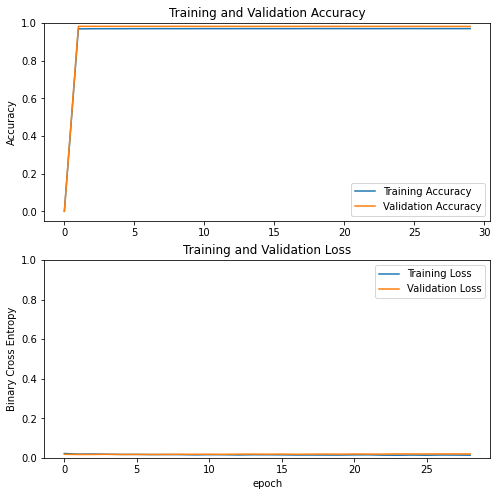

In [ ]:
#plot the training and validation accuracy
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()